In [2]:
%matplotlib inline
from osgeo import gdal, osr
import geopandas as gpd
import gdal
import os
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio
import numpy as np
import imageio
from rasterio.plot import show
import pandas as pd
import pathlib
import mapclassify as mc
import laspy
from rasterio import mask
import folium
from shapely.geometry import Polygon


In [3]:
filename= '../Data/iowa.tif'

In [4]:
ds= gdal.Open(filename)
type(ds)

osgeo.gdal.Dataset

In [5]:
#print raster info
print("Width",ds.RasterXSize, "Height", ds.RasterYSize)

Width 1499 Height 1493


In [6]:
print(ds.GetDescription)

<bound method MajorObject.GetDescription of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f4868c5ec60> >>


In [7]:
print('coordinate system',ds.GetProjection())

coordinate system PROJCS["NAD83 / UTM zone 15N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26915"]]


In [8]:
print(ds.GetGeoTransform())

(446112.3908587211, 1.0, 0.0, 4654068.19273306, 0.0, -1.0)


In [9]:
#number of raster bands 
# here is telling that its a single band raster (either binary image, represented as 0 or 1 or grayscle image o to 255 or color map) 
print(ds.RasterCount)

1


In [10]:
#raster band info
band1=ds.GetRasterBand(1)
print("Num data value", band1.GetNoDataValue())

Num data value -9999.0


In [11]:
print("min value", band1.GetMinimum())

min value None


In [12]:
print("max value", band1.GetMaximum())

max value None


In [13]:
rastArr= ds.GetRasterBand(1).ReadAsArray()
rastArr.shape

(1493, 1499)

In [14]:
rastArr

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

In [15]:
print("metadata:",ds.GetMetadata())

metadata: {'AREA_OR_POINT': 'Area'}


In [16]:
print("metadata:",ds.GetMetadata("IMAGE_STRUCTURE"))

metadata: {'COMPRESSION': 'DEFLATE', 'INTERLEAVE': 'BAND'}


In [17]:
def plot_raster(rast_data, title=''):
    """
    Plots raster tif image both in log scale(+1) and original verion
    """
    fig, (axlog, axorg) = plt.subplots(1, 2, figsize=(14,7))
    im1 = axlog.imshow(np.log1p(rast_data)) # vmin=0, vmax=2.1)
#     im2 = axorg.imshow(rast_data)

    plt.title("{}".format(title), fontdict = {'fontsize': 15})  
    plt.axis('off')
    plt.colorbar(im1, fraction=0.03)

<ipython-input-17-aaa0998cce4c>:6: RuntimeWarning: invalid value encountered in log1p
  im1 = axlog.imshow(np.log1p(rast_data)) # vmin=0, vmax=2.1)
<ipython-input-17-aaa0998cce4c>:11: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im1, fraction=0.03)


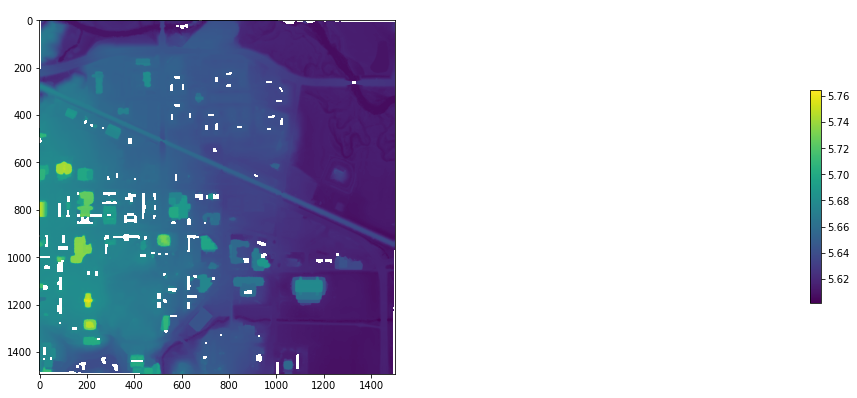

In [18]:
plot_raster(rastArr)

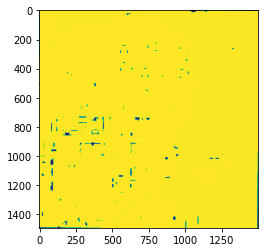

In [17]:
plt.imshow(rastArr)

In [18]:

data= rio.open(filename)
rast_ds=data.read(1)

In [19]:
count = rast_ds[rast_ds > 0].sum()

In [21]:

MINX, MINY, MAXX, MAXY = [-93.756155, 41.918015, -93.747334, 41.921429]
polygon = Polygon(((MINX, MINY), (MINX, MAXY), (MAXX, MAXY), (MAXX, MINY), (MINX, MINY)))



In [22]:

# get shp from tif
def get_shp_from_tif(tif_path:str, shp_file_path:str) -> None:
    raster = rio.open(tif_path)
    df= gpd.GeoDataFrame([polygon], columns=["geometry"])
    df.set_crs(epsg=4326, inplace=True)
  # save to file
    df.to_file(shp_file_path)
    print('Saved..')

In [23]:
from shapely.geometry import box
get_shp_from_tif('../Data/iowa.tif', shp_file_path='../Data/combi.shp')

Saved..


In [24]:

usa_gdf = (gpd.GeoDataFrame.from_file('../Data/combi.shp'))
usa_gdf.shape
usa_gdf

,FID,geometry
0,0,"POLYGON ((-93.75616 41.91801, -93.75616 41.921..."


Text(0.5, 1.0, 'USA: regions')

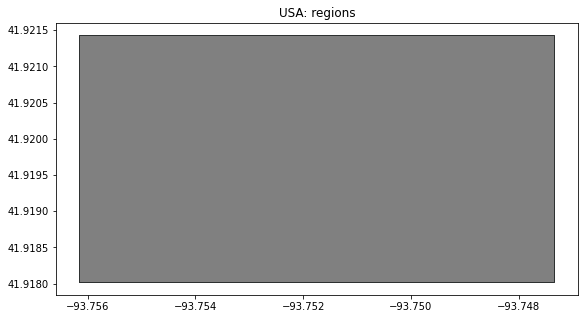

In [25]:
# plot the shapefile
plt.rcParams['figure.figsize'] = 10,5
usa_gdf.plot(color="gray", edgecolor="#2e3131", figsize=(10, 5))
plt.title('USA: regions')

In [26]:
usa_gdf['area'] = usa_gdf.area
# Returns a GeoSeries of points for each geometric centroid.
usa_gdf['centroid'] = usa_gdf.centroid
# Returns a GeoSeries of geometries representing the point or smallest rectangular
# polygon (with sides parallel to the coordinate axes) that contains each object.
usa_gdf['envelope'] = usa_gdf.envelope

<ipython-input-26-3d977b47793c>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  usa_gdf['area'] = usa_gdf.area
<ipython-input-26-3d977b47793c>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  usa_gdf['centroid'] = usa_gdf.centroid


In [27]:
print(usa_gdf.crs)

epsg:4326


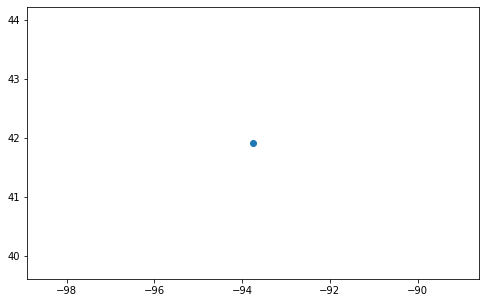

In [28]:
usa_gdf=usa_gdf.set_geometry('centroid')
usa_gdf.plot();

In [29]:
usa_gdf

,FID,geometry,area,centroid,envelope
0,0,"POLYGON ((-93.75616 41.91801, -93.75616 41.921...",0.00003,POINT (-93.75174 41.91972),"POLYGON ((-93.75616 41.91801, -93.74733 41.918..."


In [30]:
usa_g = usa_gdf.drop(['centroid', 'envelope'], axis=1)

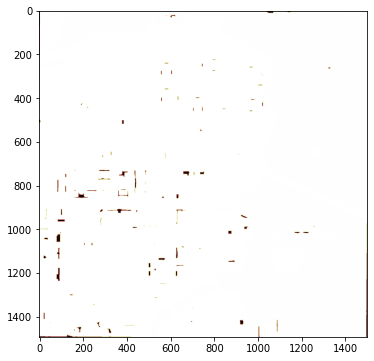

In [31]:
src = rio.open('../Data/iowa.tif')
plt.figure(figsize=(10, 6))
plt.imshow(src.read(1), cmap='pink')
plt.show()

<AxesSubplot:>

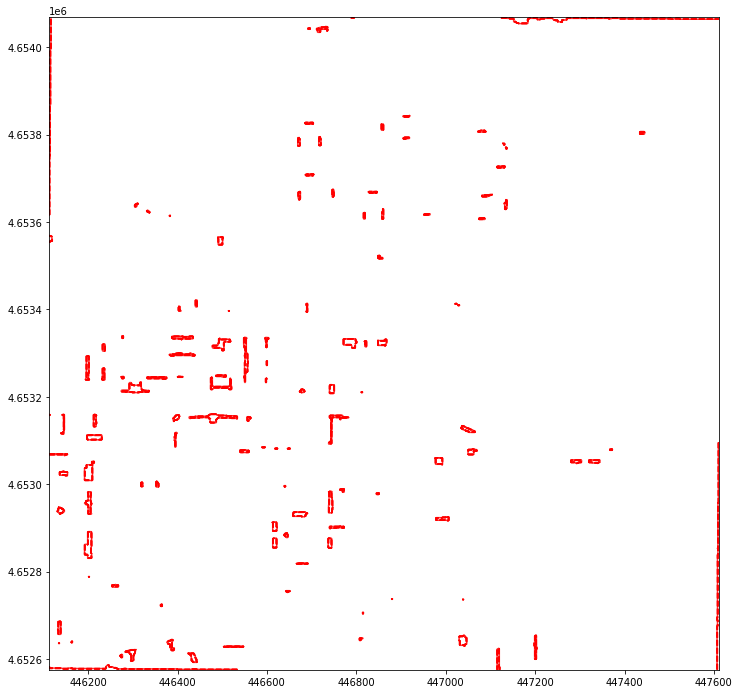

In [44]:
fig, ax = plt.subplots(1, figsize=(12, 12))
show((src, 1), ax=ax, contour=True, contour_label_kws={})

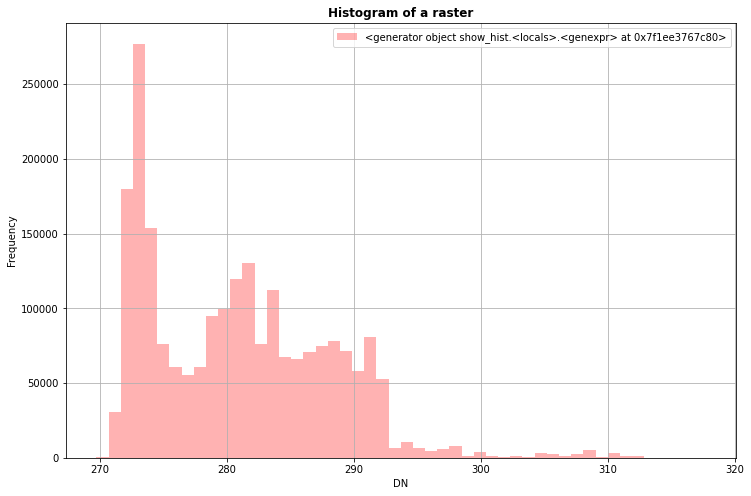

In [32]:
plt.figure(figsize=(12, 8))
from rasterio.plot import show_hist
show_hist(
    src, bins=50, lw=0.0, stacked=False, alpha=0.3,
   histtype='stepfilled', title="Histogram of a raster")

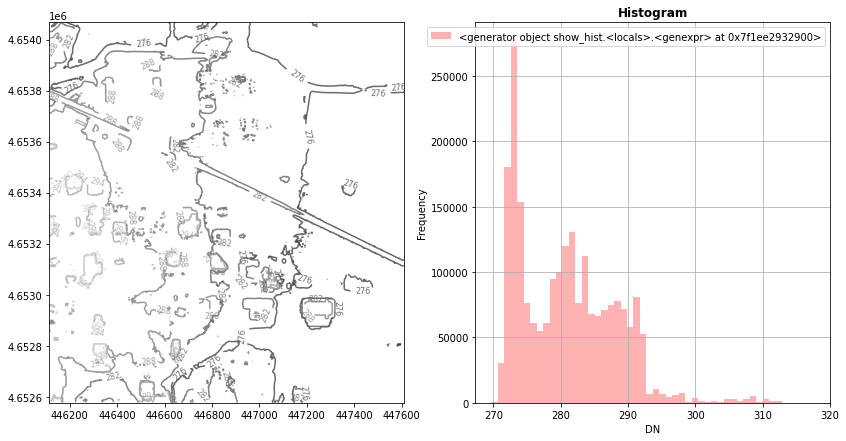

In [43]:
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show((src), cmap='Greys_r', contour=True, ax=axrgb)
show_hist(src, bins=50, histtype='stepfilled',
          lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()
